In [1]:
import sys
sys.path.append('/data/rradev/generator_reweight/')

# EOS being weird
!kinit rradev@CERN.CH -k -t rradev.keytab

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import latex
import numpy as np
import seaborn as sns
import argparse

from sklearn.metrics import classification_report
from utils.plotting import plot_distribution
from utils.funcs import calculate_weights

In [7]:
plt.rcParams['figure.figsize'] = (12, 10)

In [8]:
reweighted_samples_path = '/eos/user/r/rradev/reweighted_samples/reweighted_samples/'
col_names =  ["isNu", "isNue", "isNumu", "isNutau", "cc", "Enu_true", "ELep", "CosLep", "Q2", "W", "x", "y", "nP", "nN", "nipip", "nipim", "nipi0", "niem", "eP", "eN", "ePip", "ePim", "ePi0"]

def load_feats_logits():
    genie_feats = torch.load(reweighted_samples_path + 'GENIE_features.pt').detach().cpu().numpy()
    genie_logits = torch.load(reweighted_samples_path + 'GENIE_logits.pt').detach().cpu().numpy()
    genie = pd.DataFrame(genie_feats, columns=col_names)
    genie['logits'] = genie_logits
    genie['generator'] = 'genie'

    neut_feats = torch.load(reweighted_samples_path + 'NEUT_features.pt').detach().cpu().numpy()
    neut_logits = torch.load(reweighted_samples_path + 'NEUT_logits.pt').detach().cpu().numpy()
    neut = pd.DataFrame(neut_feats, columns=col_names)
    neut['logits'] = neut_logits
    neut['generator'] = 'neut'
    neut = neut[neut['ELep'] > 0]
    return neut, genie


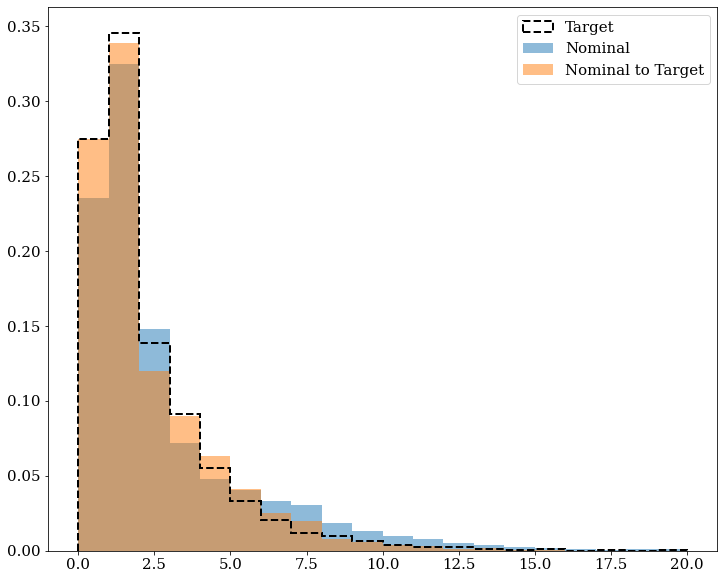

In [25]:
# Calculate weights for GENIE

neut, genie = load_feats_logits()
genie['weights'], genie['probas'] = calculate_weights(genie['logits'], weight_cap=10)
neut['weights'], neut['probas'] = calculate_weights(neut['logits'], weight_cap=10)


for variable in col_names:
    plot_distribution(genie[variable], neut[variable], genie['weights'], n_bins=20)
    plt.title('variable')
    plt.show()

In [6]:
variable = 'CosLep'
plot_distribution(genie_nue[variable], neut_nue[variable], genie_nue['weights'], n_bins=10)

NameError: name 'genie_nue' is not defined

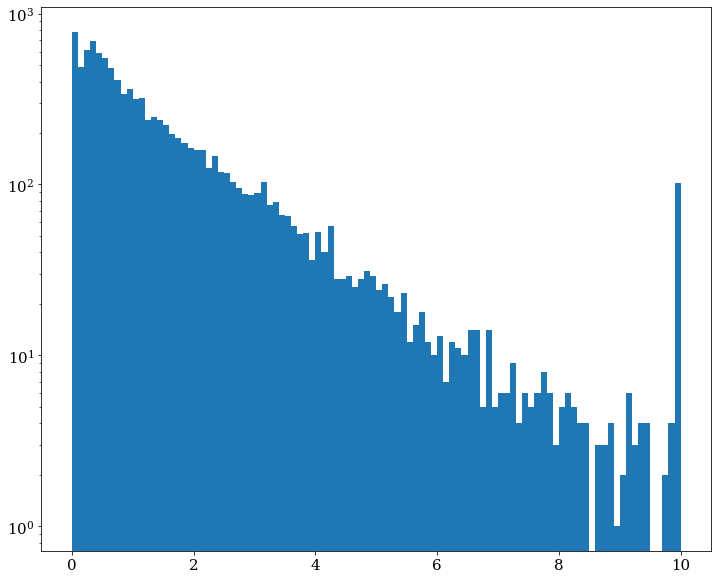

In [ ]:
plt.hist(genie['weights'], bins=100)
plt.yscale('log')

# Make Some Plots

(0.0, 401.1)

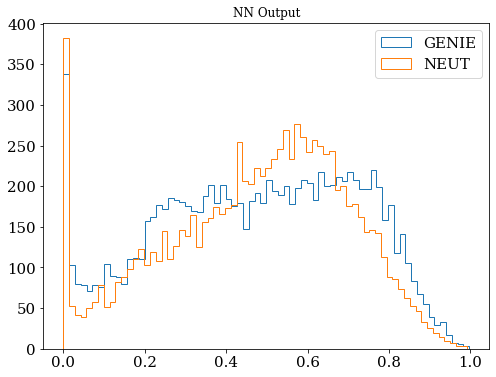

In [ ]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.hist(genie['probas'], bins=70, histtype="step", label='GENIE')
plt.hist(neut['probas'], bins=70, histtype="step", label='NEUT')
plt.legend()
plt.title('NN Output')
plt.ylim()